# Final Project: Restaurant Recommander System

## Imports

In [214]:
import pandas as pd
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics import f1_score

In [3]:
config_file = open("config.yml", "r")
config = yaml.load(config_file, Loader=yaml.FullLoader)
DATA_DIRECTORY = config["DATA_DIRECTORY"]

## Chargement des données

In [4]:
# Données relatives aux commandes des customers aux vendors
order_df = pd.read_csv(os.path.join(DATA_DIRECTORY, "orders.csv"))

# Données des vendeurs(localisation, identifiant)
vendors_df = pd.read_csv(os.path.join(DATA_DIRECTORY, "vendors.csv"))

# Données des clients (date de naissance, ID, genre)
train_customer_df = pd.read_csv(os.path.join(DATA_DIRECTORY, "train_customers.csv"))

# Localisations des clients
train_locations_df = pd.read_csv(os.path.join(DATA_DIRECTORY, "train_locations.csv"))

# Ensemble de tests sur les données des clients
test_customer_df = pd.read_csv(os.path.join(DATA_DIRECTORY, "test_customers.csv"))

# Ensemble de tests sur les localisations des clients
test_locations_df = pd.read_csv(os.path.join(DATA_DIRECTORY, "test_locations.csv"))

/run/user/22104/ipykernel_4349/3856822910.py:2: DtypeWarning: Columns (15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  order_df = pd.read_csv(os.path.join(DATA_DIRECTORY, "orders.csv"))


## Definition d'une super-classe de modèle

In [5]:
class RecommanderModel:
    model_type = "undefined"
    # Définition du schéma de sortie du modèle
    output_schema = config["output_schema"]

    def __init__(self, model_name: str) -> None:
        self.model_name = model_name
        pass

    def train(self, **kwargs) -> None:
        pass

    def predict(self, **kwargs) -> None:
        pass

    def save_predictions(self, **kwargs) -> None:
        pass

    def print_model(self):
        print(f"{self.model_type} recommander model\nmodel name: '{self.model_name}'")

In [252]:
order_with_loc_df = pd.merge(
    order_df[["customer_id", "LOCATION_NUMBER", "vendor_id", "vendor_rating","is_rated"]],
    train_locations_df,
    left_on=["customer_id", "LOCATION_NUMBER"],
    right_on=["customer_id", "location_number"],
)
order_with_loc_df["is_rated"] = order_with_loc_df["is_rated"].apply(lambda b: 1 if b =='Yes' else 0 )
order_with_loc_df["is_rated"] = order_with_loc_df["is_rated"].fillna(0)
order_with_loc_df["vendor_rating"] = order_with_loc_df["vendor_rating"].fillna(0)
order_with_loc_df

,customer_id,LOCATION_NUMBER,vendor_id,vendor_rating,is_rated,location_number,location_type,latitude,longitude
0,92PEE24,0,105,0.0,0,0,NaN,-0.132100,-78.575297
1,92PEE24,0,105,0.0,0,0,NaN,-0.132100,-78.575297
2,92PEE24,0,105,0.0,0,0,NaN,-0.132100,-78.575297
3,QS68UD8,0,294,0.0,0,0,Work,-0.393396,-78.544417
4,MB7VY5F,0,83,0.0,0,0,NaN,-1.072823,-78.464121
...,...,...,...,...,...,...,...,...,...
135298,3S6VG6R,1,199,5.0,1,1,NaN,2.284875,0.717124
135299,ND4PIJL,0,907,0.0,0,0,NaN,13.380083,-1.387421
135300,1NRK5HF,0,105,0.0,0,0,NaN,-0.772600,0.231851
135301,QDXLWM7,1,28,0.0,0,1,NaN,1.751487,0.375234


In [263]:
train_order_df, test_order_df = train_test_split(
    order_with_loc_df, test_size=0.2, random_state=42
)
train_order_df, val_order_df = train_test_split(
    train_order_df, test_size=0.2, random_state=42
)
train_order_df

,customer_id,LOCATION_NUMBER,vendor_id,vendor_rating,is_rated,location_number,location_type,latitude,longitude
121366,5ARTXD7,1,681,5.0,1,1,NaN,-0.036682,-0.069342
63263,JTDL6KB,0,386,0.0,0,0,NaN,-0.492942,0.179312
30695,H9REAWE,0,78,0.0,0,0,Home,-0.025458,-78.587900
80592,7I7SY2D,1,4,0.0,0,1,NaN,0.415142,0.931376
132382,EIA3K80,3,92,0.0,0,3,Other,0.107888,0.596460
...,...,...,...,...,...,...,...,...,...
25191,4QNVW0N,1,176,0.0,0,1,Other,0.141303,-78.607609
35276,NBHJZZB,0,78,0.0,0,0,NaN,0.275762,-78.623499
124517,3I2NFF0,0,289,0.0,0,0,NaN,0.431060,-0.005375
51877,0Z52KAY,1,843,0.0,0,1,NaN,-0.795356,0.082256


## Funk SVD

Get Y and R matrices

In [266]:



# Créer une table pivot en utilisant 'customer_id', 'vendor_id' et 'LOCATION_NUMBER' comme index
Y_matrix = pd.pivot_table(train_order_df, 
                                values='vendor_rating', 
                                index='customer_id', 
                                columns='vendor_id', 
                                fill_value=0)

# Afficher la matrice d'évaluation utilisateur-vendeur
Y_matrix

vendor_id,4,13,20,23,28,33,43,44,55,66,...,681,841,843,845,846,849,855,856,858,907
customer_id,,,,,,,,,,,,,,,,,,,,,
000THBA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
005ECL6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0075AM7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
009UFS1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00F8I3F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZZVGIVK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZZVLIB5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZZWKMGG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [281]:
rated_or_not_df = pd.pivot_table(train_order_df, values='is_rated', index='customer_id', 
                                columns='vendor_id',
                                fill_value=0)

rated_or_not_df.applymap(lambda x : 1 if x!=0 else x)


vendor_id,4,13,20,23,28,33,43,44,55,66,...,681,841,843,845,846,849,855,856,858,907
customer_id,,,,,,,,,,,,,,,,,,,,,
000THBA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
005ECL6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0075AM7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
009UFS1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00F8I3F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZZVGIVK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZZVLIB5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZZWKMGG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


100 vendors and 23142 customers.


Get customer and vendor matrices.

In [347]:
class FunkSVD():
    def __init__(self,Y_matrix: pd.DataFrame,rated_or_not_df: pd.DataFrame, latent_dim: int):
        self.latent_dim = latent_dim
        self.Y_matrix = Y_matrix
        self.rated_or_not_df = rated_or_not_df
        self.hist = {}
    def fit(self, max_iteration:int = 5, learning_rate:float = 0.0001):
        assert (self.Y_matrix.shape == self.rated_or_not_df.shape) , f"Different shapes {self.Y_matrix.shape =} and {self.rated_or_not_df.shape =} "
        seed = 16
        n_customer, n_vendor  = self.Y_matrix.shape
        print(f'{n_vendor} vendors and {n_customer} customers.')
        self.hist["mse"] = []
        np.random.seed(seed)
        customer_mat = np.random.rand(n_customer, self.latent_dim)
        vendor_mat = np.random.rand(self.latent_dim, n_vendor)
        for i in range(max_iteration):
            mask = self.rated_or_not_df > 0
            diff_mat = self.Y_matrix - np.dot(customer_mat,vendor_mat)
            n_ratings = len(diff_mat)
            print(n_ratings)
            diff_mat /= n_ratings
            mse = np.sum(np.sum(np.square(diff_mat[mask])))
            self.hist["mse"].append(mse)
            customer_mat += learning_rate * np.dot(diff_mat,vendor_mat.T)
            vendor_mat += learning_rate * np.dot(customer_mat.T, diff_mat)
        
        self.customer_mat =customer_mat
        self.vendor_mat = vendor_mat

100 vendors and 23142 customers.
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142
23142


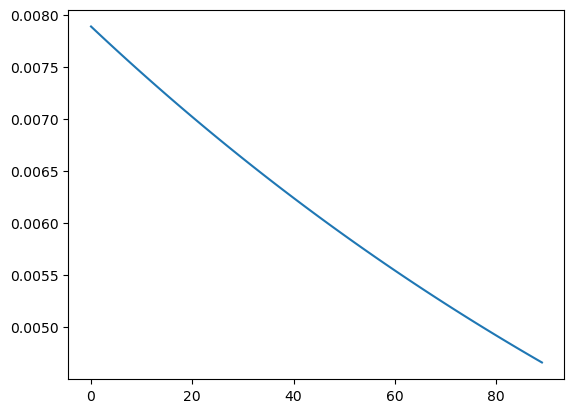

In [348]:
svd = FunkSVD(Y_matrix,rated_or_not_df,100)
svd.fit(max_iteration=100)
plt.plot(svd.hist["mse"][10:]);

In [239]:
VAL_KEY = 'val'
PRED_KEY = 'pred'
VALIDATION_KEY = 'validation'
TRAIN_KEY = 'training'



In [241]:
def generate_comparison_df(train_set,val_set):
    train_set = train_set.rename(columns={PRED_KEY: TRAIN_KEY })
    val_set = val_set.rename(columns={PRED_KEY: VALIDATION_KEY})
    comparison_df = pd.merge(train_set,val_set,on=VAL_KEY)
    return comparison_df

def calculate_f1_score(train_set,val_set):
    df = generate_comparison_df(train_set,val_set)
    true_labels = df[VALIDATION_KEY]
    predicted_labels = df[TRAIN_KEY]

    f1 = f1_score(true_labels, predicted_labels)

    return f1

calculate_f1_score(train_set,val_set)

0.6060606060606061